# $\beta$-pic b planet

In this notebook I aim to reproduce the same posteriors as in the paper of [Sun et al](https://arxiv.org/pdf/2201.08506.pdf)

## Import the necessary packages 

In [1]:
import os

# Set the directory to the root of the project
os.chdir('../')

import torch
import h5py
import numpy as np
from orbitize import read_input, DATADIR
from orbitize.system import seppa2radec, transform_errors
from astropy.time import Time # Needed to convert from MJD to gregorian date
from helpers import Simulator, Prior
from plots import plot_orbit, corner_plot, radec_plot


## Load the dataset with the observations

In [2]:
data_table = read_input.read_file('{}/betaPic.csv'.format(DATADIR))
data_table = data_table[:-1] # Discard the  RV observation, as we do not take it into account in the model
data_table

epoch,object,quant1,quant1_err,quant2,quant2_err,quant12_corr,quant_type,instrument
float64,int64,float64,float64,float64,float64,float64,bytes5,bytes5
54781.0,1,210.0,27.0,211.49,1.9,nan,seppa,defsp
52953.0,1,413.0,22.0,34.0,4.0,nan,seppa,defsp
55129.0,1,299.0,14.0,211.0,3.0,nan,seppa,defsp
55194.0,1,306.0,9.0,212.1,1.7,nan,seppa,defsp
55296.0,1,346.0,7.0,209.9,1.2,nan,seppa,defsp
55467.0,1,383.0,11.0,210.3,1.7,nan,seppa,defsp
55516.0,1,387.0,8.0,212.4,1.4,nan,seppa,defsp
55517.0,1,390.0,13.0,212.0,2.0,nan,seppa,defsp
55593.0,1,408.0,9.0,211.1,1.5,nan,seppa,defsp


Transform the values that are currently in the sep/pa format to the ra/dec format. Note that the function transforming the errors is not vectorisable but it is not such a problem because it is only for $\pm$ 30 values

In [3]:
ra_errs = []
dec_errs = []
corrs = []
ra, dec = seppa2radec(data_table["quant1"], data_table["quant2"])

for i in range(len(data_table)):
    
    ra_err, dec_err, corr = transform_errors(data_table["quant1"][i], 
                                             data_table["quant2"][i], 
                                             data_table["quant1_err"][i], 
                                             data_table["quant2_err"][i], 
                                             data_table["quant12_corr"][i], 
                                             seppa2radec)
    ra_errs.append(ra_err)
    dec_errs.append(dec_err)
    corrs.append(corr)

data_table["quant1"] = ra
data_table["quant2"] = dec
data_table["quant1_err"] = ra_errs
data_table["quant2_err"] = dec_errs
data_table["quant12_corr"] = corr
data_table["quant_type"] = ["radec" for i in range(len(data_table))]

## Define the priors
The priors are defined as such 
$$
\begin{align*}
a &\sim \log \mathcal{U}(4, 40)\\
e &\sim \mathcal{U}(10^{5}, 0.99)\\
i &\sim \text{Sine}(81, 99)\\
\omega &\sim \mathcal{U}(0,360)\\
\Omega &\sim \mathcal{U}(25,85)\\
\tau &\sim \mathcal{U}(0,1)\\
\pi &\sim \mathcal{N}(51.44, 0.12) \\
M_T &\sim \mathcal{N}(1.75,0.05)\\
\end{align*}
$$

They were taken from [Sun et al](https://arxiv.org/pdf/2201.08506.pdf), note that there is an error in the paper as the parallax and the total mass shown are from GJ 504, and not $\beta$-pictoris

In [4]:
priors = Prior()
priors.sample([1,])

tensor([[19.1665,  0.5056, 95.9228, 55.4520, 25.1568,  0.7507, 51.5665,  1.7180]],
       dtype=torch.float64)

# Define the simulator

In [5]:
simulator = Simulator(data_table)

# Test the simulator

To verify that the simulator is working correctly, we can plot a simulated orbit. 

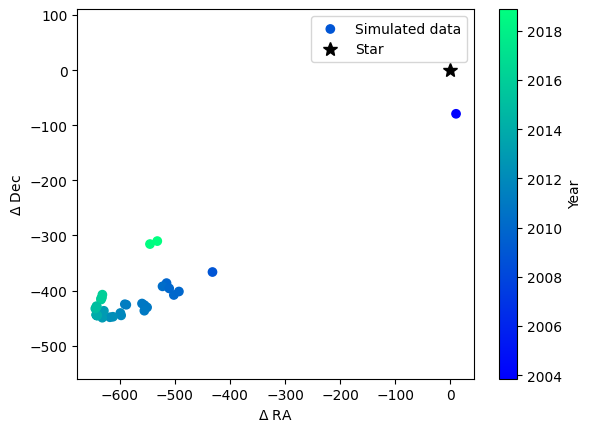

In [6]:
theta = priors.sample([1,])
x = simulator(theta)*1e6

timestep = Time(data_table['epoch'], format='mjd').decimalyear # Convert from MJD to decimal year

plot_orbit(theta, x[0], timestep=timestep)

The plot can then be compared to the real observations $x^{*}$

First we format the data in the same way the simulator does

/tmp/ipykernel_18242/2555166031.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  ra_bp = torch.tensor([data_table['quant1'].data])


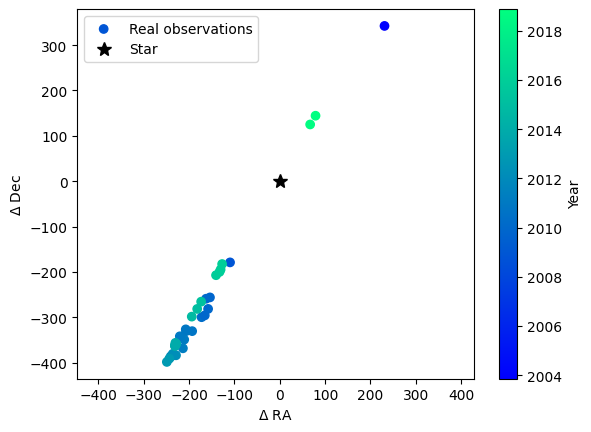

In [7]:
ra_bp = torch.tensor([data_table['quant1'].data])
dec_bp = torch.tensor([data_table['quant2'].data])

x_star = torch.empty(2 * len(data_table), dtype=torch.float32)

x_star[0::2] = ra_bp
x_star[1::2] = dec_bp

plot_orbit(theta, x_star, label="Real observations", timestep=timestep)

---

# Compare the model with MCMC

Load the trained model and generate samples

In [16]:
# Transform the NPE observations to the same format as the
# observations used to train the model
ra_obs = torch.tensor([data_table['quant1'].data])
dec_obs = torch.tensor([data_table['quant2'].data])
x_star = torch.empty(2 * len(data_table), dtype=torch.float32)
x_star[0::2] = ra_obs
x_star[1::2] = dec_obs
x_star = x_star / 1e6 # Scale the observations to the same scale as the training data

estimator = torch.load('models/npe-betapic.pth')

with torch.no_grad():
    npe_samples = estimator.flow(x_star.cuda()).sample((2**16,)).cpu()

    valid_rows = (npe_samples >= -1) & (npe_samples <= 1) # Check if the samples are within the bounds of the prior
    valid_rows = valid_rows.all(axis=1)
    npe_samples = npe_samples[valid_rows]
    npe_samples = priors.post_process(npe_samples)

Load the mcmc samples

In [9]:
filename = 'models/mcmc_betapic.hdf5'
hf = h5py.File(filename,'r') 
post = np.array(hf.get('post'))
hf.close() 

# Reshape the samples to the correct shape and remove the 
# 8000 burn-in samples for each chain
mcmc_samples = post.reshape((1000, 10000, 8))
mcmc_samples = mcmc_samples[:, 8000:, :]
mcmc_samples = mcmc_samples.reshape([-1, 8]) 

# Convert the angles from radians to degrees
mcmc_samples[:,2] = np.rad2deg(mcmc_samples[:,2])
mcmc_samples[:,3] = np.rad2deg(mcmc_samples[:,3])
mcmc_samples[:,4] = np.rad2deg(mcmc_samples[:,4])

## Corner plot

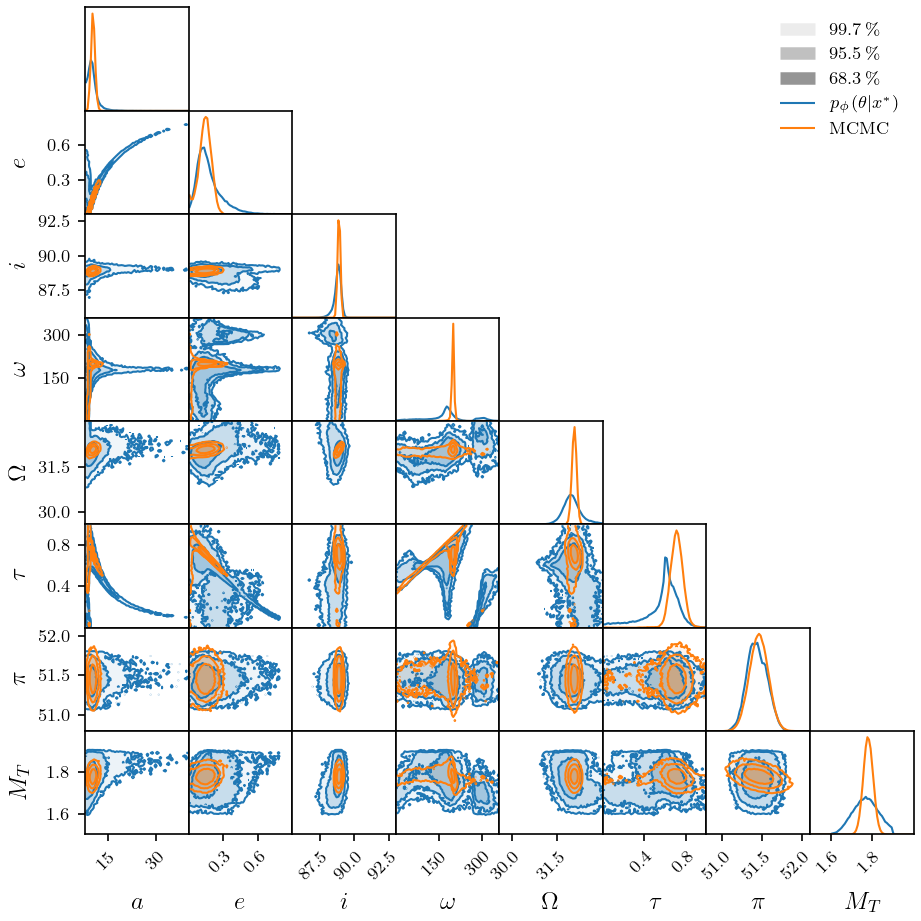

In [17]:
corner_plot(npe_samples, mcmc_samples)

## Ra-Dec plot
We generate 5000 orbits and take the confidence interval for the NPE model and the MCMC model

### NPE

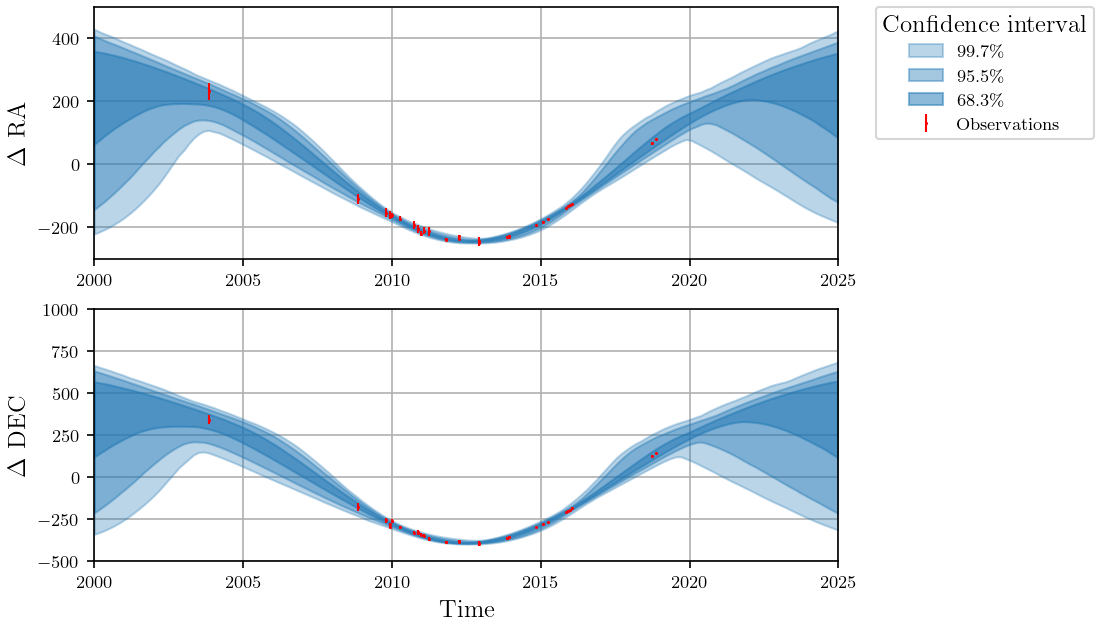

In [30]:
radec_plot(npe_samples, data_table)

### MCMC

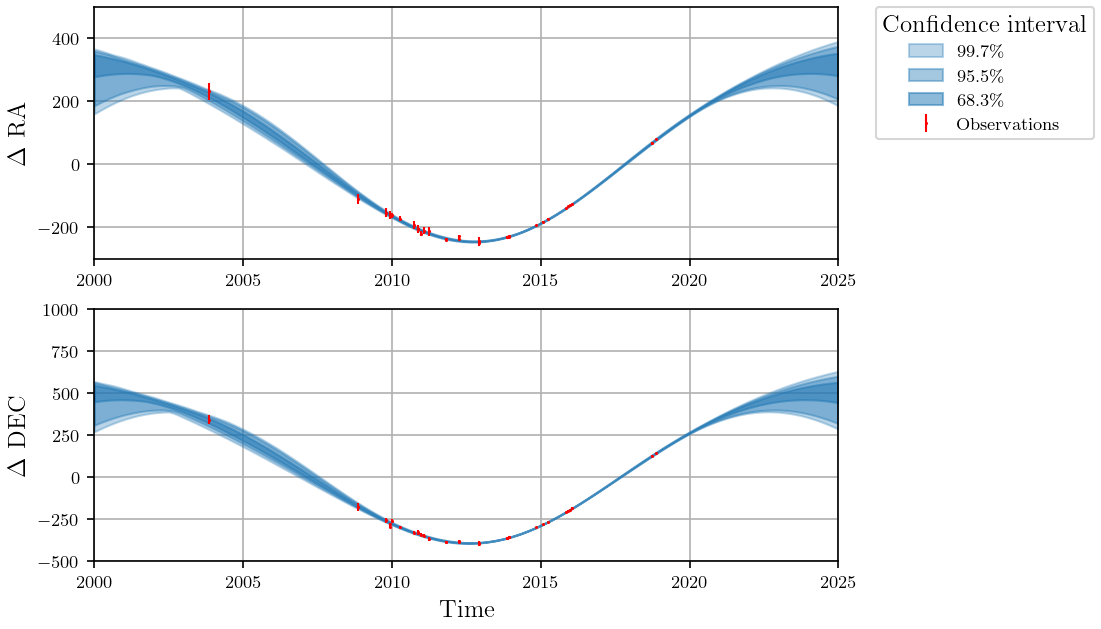

In [31]:
radec_plot(mcmc_samples, data_table)

---